# OBIA in Python

This notebook is support material for the blog post here: http://www.machinalis.com/blog/obia/

The code in the blog has been simplified so it may differ from what's done here.


In [8]:
%matplotlib notebook

import numpy as np
import os
import scipy

from matplotlib import pyplot as plt
from matplotlib import colors
from osgeo import gdal
from skimage import exposure
from skimage.segmentation import quickshift, felzenszwalb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import geog432

LANDSAT8_BASE = os.path.join(os.getcwd(), "landsat8")
LANDSAT8 = "landsat8/pg.tif"
LANDSAT8_TRAIN = "landsat8/train/"
LANDSAT8_TEST = "landsat8/test/"

SEN2_BASE = os.path.join(os.getcwd(), "sentinel")
SEN2 = "sentinel/pg.tif"
SEN2_TRAIN = "sentinel/train/"
SEN2_TEST = "sentinel/test/"

BASE_DIR = LANDSAT8_BASE
RASTER_DATA_FILE = LANDSAT8
TRAIN_DATA_PATH = LANDSAT8_TRAIN

First, define some helper functions (taken from http://www.machinalis.com/blog/python-for-geospatial-data-processing/)

In [9]:

def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize all the vectors in the given directory into a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


In [10]:
raster_dataset = gdal.Open(RASTER_DATA_FILE, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
n_bands = raster_dataset.RasterCount
bands_data = []
for b in range(1, n_bands+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(b for b in bands_data)

print(bands_data.shape, type(bands_data[0][0][0]), bands_data[0][0][0])

(784, 1297, 7) <class 'numpy.float32'> 0.0


Create images

In [11]:
img = exposure.rescale_intensity(bands_data)
img = bands_data
rgb_img = np.dstack([img[:, :, 2], img[:, :, 1], img[:, :, 0]])

<IPython.core.display.Javascript object>


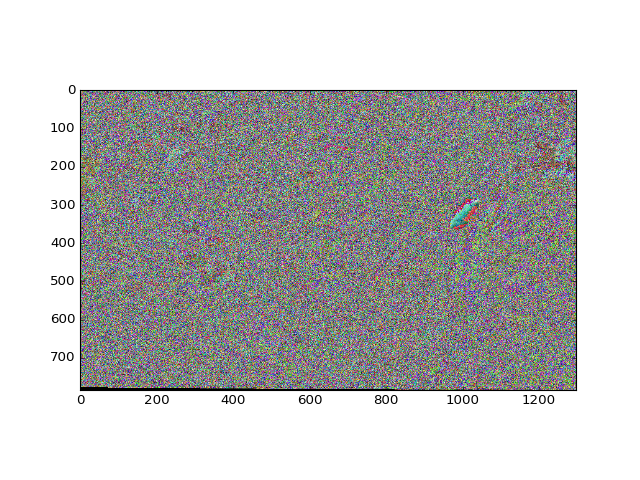

In [12]:
plt.figure()
plt.imshow(rgb_img)

skimage.segmentation.felzenszwalb is not prepared to work with multi-band data. So, based on their own implementation for RGB images, I apply the segmentation in each band and then combine the results. See:
http://github.com/scikit-image/scikit-image/blob/v0.12.3/skimage/segmentation/_felzenszwalb.py#L69

In [6]:
band_segmentation = []
for i in range(n_bands):
    band_segmentation.append(felzenszwalb(img[:, :, i], scale=85, sigma=0.25, min_size=9))

ValueError: Images of type float must be between -1 and 1.

put pixels in same segment only if in the same segment in all bands. We do this by combining the band segmentation to one number

In [ ]:
const = [b.max() + 1 for b in band_segmentation]
segmentation = band_segmentation[0]
for i, s in enumerate(band_segmentation[1:]):
    segmentation += s * np.prod(const[:i+1])

_, labels = np.unique(segmentation, return_inverse=True)
segments_felz = labels.reshape(img.shape[:2])

In [ ]:
cmap = colors.ListedColormap(np.random.rand(len(np.unique(segments_felz)), 3))
plt.figure()
plt.imshow(segments_felz, interpolation='none', cmap=cmap)


In [ ]:
# Write image for reference
plt.imsave(os.path.join(BASE_DIR, "ls8_segments.png"), segments_felz, cmap=cmap, format="png")

In [ ]:
# We choose the quick segmentation
segments = segments_felz
segment_ids = np.unique(segments_felz)
print("Felzenszwalb segmentation. %i segments." % len(segment_ids))

In [ ]:
rows, cols, n_bands = img.shape
files = [f for f in os.listdir(TRAIN_DATA_PATH) if f.endswith('.shp')]
classes_labels = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(TRAIN_DATA_PATH, f) for f in files if f.endswith('.shp')]
print(shapefiles)

In [ ]:
ground_truth = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

In [ ]:
classes = np.unique(ground_truth)[1:]  # 0 doesn't count
len(classes)

In [ ]:
segments_per_klass = {}
for klass in classes:
    segments_of_klass = segments[ground_truth==klass]
    segments_per_klass[klass] = set(segments_of_klass)
    print("Training segments for class %i: %i" % (klass, len(segments_per_klass[klass])))

## Disambiguation
Check if there are segments which contain training pixels of different classes.

In [ ]:
accum = set()
intersection = set()
for class_segments in segments_per_klass.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0

### ¡No need to disambiguate!

Next, we will _paint in black_ all segments that are not for training.
The training segments will be painted of a color depending on the class.

To do that we'll set as threshold the max segment id (max segments image pixel value). 
Then, to the training segments we'll assign values higher than the threshold.
Finally, we assign 0 (zero) to pixels with values equal or below the threshold.

In [ ]:
train_img = np.copy(segments)
threshold = train_img.max() + 1
for klass in classes:
    klass_label = threshold + klass
    for segment_id in segments_per_klass[klass]:
        train_img[train_img == segment_id] = klass_label
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold

### Lets see the training segments

In [ ]:
plt.figure()
cm = np.array([[ 1,  1,  1 ], [ 1,0,0], [ 1,0,1], [ 0,1,0], [ 0,1,1], [ 0,0,1]])
cmap = colors.ListedColormap(cm)
plt.imshow(train_img, cmap=cmap)
plt.colorbar(ticks=[0,1,2,3,4,5])
plt.imsave(os.path.join(BASE_DIR, "ls8_training_segments.png"), train_img, cmap=cmap, format="png")

# Training data

So now, we transform each training segment into a _segment model_ and thus creating the training dataset.

In [ ]:
def segment_features(segment_pixels):
    """For each band, compute: min, max, mean, variance, skewness, kurtosis"""
    features = []
    n_pixels, n_bands = segment_pixels.shape
    for b in range(n_bands):
        stats = scipy.stats.describe(segment_pixels[:,b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if n_pixels == 1:
            # scipy.stats.describe raises a Warning and sets variance to nan
            band_stats[3] = 0.0  # Replace nan with something (zero)
        features += band_stats
    return features


### Create all the objects: 
compute the features' vector for each segment (and append the segment ID as reference)

In [ ]:
# This is the most heavy part of the process. It could take about half an hour to finish in a not-so-fast CPU
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    objects = []
    objects_ids = []
    for segment_label in segment_ids:
        segment_pixels = img[segments==segment_label]
        segment_model = segment_features(segment_pixels)
        objects.append(segment_model)
        # Keep a reference to the segment label
        objects_ids.append(segment_label)  

    print("Created %i objects" % len(objects))

### Subset the training data

In [ ]:
training_labels = []
training_objects = []
for klass in classes:
    class_train_objects = [v for i, v in enumerate(objects) if objects_ids[i] in segments_per_klass[klass]]
    training_labels += [klass] * len(class_train_objects)
    print("Training samples for class %i: %i" % (klass, len(class_train_objects)))
    training_objects += class_train_objects

# Train a classifier

In [ ]:
classifier = RandomForestClassifier(n_jobs=-1)

In [ ]:
classifier.fit(training_objects, training_labels)

# Classify all segments
Now we have to transform all segments into a _segment models_ in order to classify them

In [ ]:
predicted = classifier.predict(objects)

# Propagate the classification
Now that each segment has been classified, we need to propagate that classification to the pixel level. That is, given the class **k** for the segment with label **S**, generate a classification from the segmented image where all pixels in segment **S** are assigned the class **k**.

In [ ]:
clf = np.copy(segments)

In [ ]:
for segment_id, klass in zip(objects_ids, predicted):
    clf[clf==segment_id] = klass

In [ ]:
plt.figure()
cmap = colors.ListedColormap(np.random.rand(len(classes_labels), 3))
plt.imshow(clf, interpolation='none', cmap=cmap)


In [ ]:
# Write GeoTiff
geog432.write_geotiff(os.path.join(BASE_DIR, "sen_obia_class_python.tif"), clf, geo_transform, proj, classes_labels)